##Analyzing Anomalies in Measles and Rubella Incidence Rates Using Isolation Forest

It identifies unusual changes in measles and rubella cases reported each year.
These unusual patterns, known as anomalies, show when unexpected events occur.
They may indicate disease outbreaks or drops in vaccination coverage.
Sometimes they can also reveal missing or incorrect data in reports.
I used the Isolation Forest model in this project because it is effective for detecting unusual patterns in time-series data, works well with limited yearly data, and does not require predefined labels for normal or abnormal cases.

In [1]:
!pip install pandas numpy scikit-learn matplotlib openpyxl ipywidgets --quiet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 19.0 MB/s eta 0:00:00


In [2]:
from IPython.display import display
import ipywidgets as widgets
import pandas as pd, numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import IsolationForest
from google.colab import files

In [4]:
print("Please upload your 'Measles_Rubella_Final.xlsx' file")
uploaded = files.upload()
file_path = list(uploaded.keys())[0]


Please upload your 'Measles_Rubella_Final.xlsx' file


Saving Measles_Rubella_Final.xlsx to Measles_Rubella_Final.xlsx


In [5]:
df = pd.read_excel(file_path, sheet_name="Sheet1")
df.columns = [str(c).strip().replace("\n"," ").replace("\r"," ") for c in df.columns]
df["Year"] = pd.to_numeric(df["Year"], errors="coerce")
df = df.dropna(subset=["Year"])
df["Year"] = df["Year"].astype(int)

# Clean numeric columns
num_cols = [
    "Measles_Cases", "Rubella_Cases", "Population",
    "Measles_Cases_Per_100K", "Rubella_Cases_Per_100K"
]
for c in num_cols:
    if c in df.columns:
        df[c] = pd.to_numeric(df[c], errors="coerce")

countries = sorted(df["Country"].dropna().unique().tolist())
print(f"✅ Loaded {len(df)} rows and found {len(countries)} countries.")


✅ Loaded 2716 rows and found 193 countries.


In [6]:
def robust_z(x):
    """Median Absolute Deviation–based z-score (robust to outliers)."""
    x = pd.Series(x).astype(float)
    med = x.median()
    mad = (x - med).abs().median()
    if mad == 0:
        s = x.std(ddof=0)
        return (x - x.mean()) / (s if s else 1.0)
    return 0.6745 * (x - med) / (mad if mad else 1.0)

def build_features(series_dict):
    """Create rolling statistical features for one or two time series."""
    def feats(s):
        s = s.interpolate().fillna(method="bfill").fillna(method="ffill")  # 🧹 Clean NaNs
        return pd.DataFrame({
            "value": s,
            "roll_mean": s.rolling(3, min_periods=1).mean(),
            "roll_std": s.rolling(3, min_periods=1).std().fillna(0),
            "robust_z": robust_z(s),
            "pct_change": s.pct_change().fillna(0),
        }, index=s.index)

    if len(series_dict) == 2:
        fm = feats(series_dict["measles"]).add_prefix("Measles_")
        fr = feats(series_dict["rubella"]).add_prefix("Rubella_")
        return pd.concat([fm, fr], axis=1)
    else:
        return feats(list(series_dict.values())[0])

def fit_iforest(X, contamination=0.05):
    """Train Isolation Forest on numeric matrix."""
    X = X.fillna(0)  # 🧹 Ensure no NaNs remain
    clf = IsolationForest(
        n_estimators=300,
        max_samples="auto",
        contamination=contamination,
        random_state=42,
        n_jobs=-1,
    )
    clf.fit(X)
    return clf.decision_function(X), clf.predict(X)  # -1 = anomaly


Dropdown(description='🌍 Country:', layout=Layout(width='50%'), options=('Afghanistan', 'Albania', 'Algeria', '…

Button(button_style='success', description='🔍 Run Anomaly Detection', style=ButtonStyle())

Running anomaly detection for Belarus …


/tmp/ipython-input-2874031307.py:14: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  s = s.interpolate().fillna(method="bfill").fillna(method="ffill")  # 🧹 Clean NaNs
/tmp/ipython-input-2874031307.py:14: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  s = s.interpolate().fillna(method="bfill").fillna(method="ffill")  # 🧹 Clean NaNs
/tmp/ipython-input-2874031307.py:14: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  s = s.interpolate().fillna(method="bfill").fillna(method="ffill")  # 🧹 Clean NaNs
/tmp/ipython-input-2874031307.py:14: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  s = s.interpolate().fillna(method="bfill").fillna(method="ffill") 

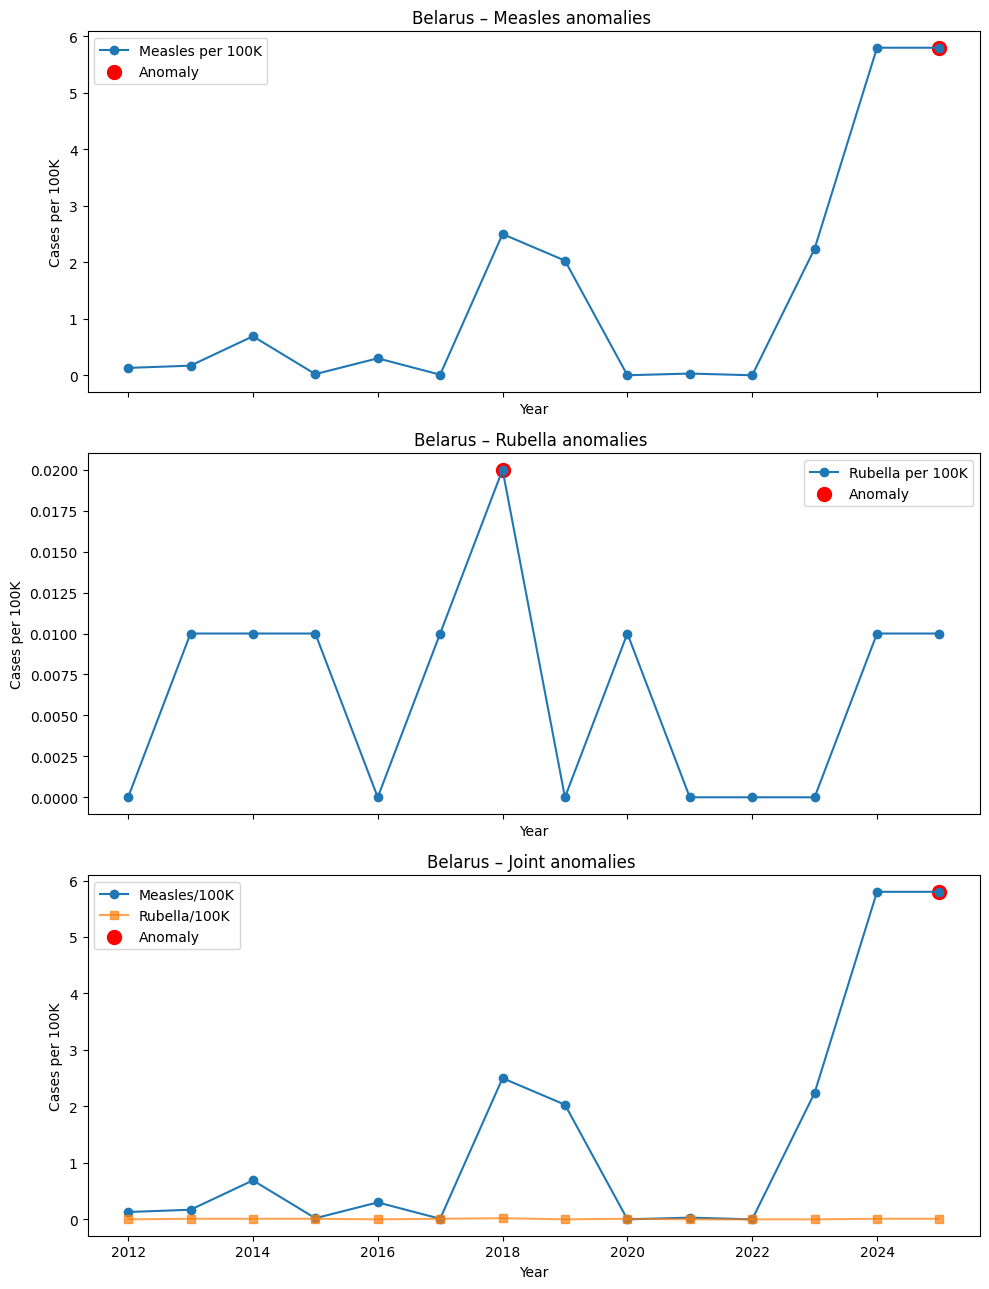

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

✅ Exported Belarus_measles_anomalies.csv


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

✅ Exported Belarus_rubella_anomalies.csv


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

✅ Exported Belarus_joint_anomalies.csv


In [11]:

country_dropdown = widgets.Dropdown(
    options=countries,
    description='🌍 Country:',
    style={'description_width': 'initial'},
    layout=widgets.Layout(width='50%')
)
display(country_dropdown)

def run_anomaly_detection(country):
    contamination = 0.05
    region = df.loc[df["Country"] == country, "Region"].iloc[0]
    df_country = df[df["Country"] == country].sort_values("Year")

    modes = ["measles", "rubella", "joint"]
    results = {}

    for mode in modes:
        if mode == "joint":
            s_meas = df_country.set_index("Year")["Measles_Cases_Per_100K"]
            s_rub = df_country.set_index("Year")["Rubella_Cases_Per_100K"]
            X = build_features({"measles": s_meas, "rubella": s_rub})
        elif mode == "measles":
            s_meas = df_country.set_index("Year")["Measles_Cases_Per_100K"]
            X = build_features({"measles": s_meas})
        else:
            s_rub = df_country.set_index("Year")["Rubella_Cases_Per_100K"]
            X = build_features({"rubella": s_rub})

        scores, labels = fit_iforest(X, contamination=contamination)
        X["if_score"] = scores
        X["if_label"] = labels
        X["is_anomaly"] = (X["if_label"] == -1).astype(int)
        results[mode] = X.copy()

    # ---------- PLOTS ----------
    fig, axes = plt.subplots(3, 1, figsize=(10, 13), sharex=True)
    for ax, mode in zip(axes, modes):
        X = results[mode]
        if mode == "joint":
            ax.plot(X.index, X["Measles_value"], marker="o", label="Measles/100K")
            ax.plot(X.index, X["Rubella_value"], marker="s", label="Rubella/100K", alpha=0.7)
        else:
            ax.plot(X.index, X["value"], marker="o", label=f"{mode.capitalize()} per 100K")
        ax.scatter(
            X[X["is_anomaly"] == 1].index,
            X[X["is_anomaly"] == 1].iloc[:, 0],
            color="red", s=100, label="Anomaly"
        )
        ax.set_title(f"{country} – {mode.capitalize()} anomalies ")
        ax.set_xlabel("Year")
        ax.set_ylabel("Cases per 100K")
        ax.legend()

    plt.tight_layout()
    plt.show()


    for mode, X in results.items():
        out = X.reset_index().copy()
        out.insert(0, "Region", region)
        out.insert(1, "Country", country)
        output_file = f"{country}_{mode}_anomalies.csv"
        out.to_csv(output_file, index=False)
        files.download(output_file)
        print(f"✅ Exported {output_file}")

run_button = widgets.Button(description="🔍 Run Anomaly Detection", button_style='success')
display(run_button)

def on_button_click(b):
    selected_country = country_dropdown.value
    print(f"Running anomaly detection for {selected_country} …")
    run_anomaly_detection(selected_country)

run_button.on_click(on_button_click)